## Package Definitions and Installation

In [1]:
!git clone https://github.com/ylacombe/musicgen-dreamboothing.git
!pip install -U git+https://github.com/huggingface/transformers

Cloning into 'musicgen-dreamboothing'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 152 (delta 14), reused 13 (delta 13), pack-reused 135 (from 1)
Receiving objects: 100% (152/152), 5.72 MiB | 36.81 MiB/s, done.
Resolving deltas: 100% (75/75), done.
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-bamx6dyj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-bamx6dyj
  Resolved https://github.com/huggingface/transformers to commit 51d732709e5ae424e8fb6c4e58b72057a3e413c2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.53.0.dev0-py3-none-any.whl size=11363407 sha256=1b8edad0a15aaf8b0c352a32d59d8598943e5ddb83fb2580ba70f74611361e7a
  Stored in directory:

In [2]:
%pip install --user -U transformers peft torch accelerate sentencepiece "datasets[audio]>=2.12.0" wandb evaluate torchaudio soundfile "black~=23.1" "isort>=5.5.4" "ruff>=0.0.241,<=0.0.259" msclap librosa demucs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

## Download and Load Data

In [3]:
# Download audio data
!wget https://zenodo.org/records/10278066/files/edm_tr9_drm_id_001.tar.gz?download=1 -O edm_data.tar.gz

!rm -rf edm_data

!mkdir edm_data

!tar xzf edm_data.tar.gz -C edm_data

!rm -rf edm_data.tar.gz #save storage

--2025-06-02 06:34:50--  https://zenodo.org/records/10278066/files/edm_tr9_drm_id_001.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4810529632 (4.5G) [application/octet-stream]
Saving to: ‘edm_data.tar.gz’

edm_data.tar.gz     100%[===================>]   4.48G  22.8MB/s    in 3m 33s  

2025-06-02 06:38:24 (21.6 MB/s) - ‘edm_data.tar.gz’ saved [4810529632/4810529632]



In [5]:
import os
import csv

from datasets import DatasetDict

from transformers import AutoProcessor, AutoModelForTextToWaveform
import torch
import soundfile as sf
import IPython.display as ipd

import scipy.io.wavfile as wav
import numpy as np

2025-06-02 06:39:46.007861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748846386.190473      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748846386.245807      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
print(torch.__version__)

print(np.__version__)

2.7.0+cu126
1.26.4


## Set Global Variables

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUGMENT = True

DATA_PATH = "./edm_data"
AUDIO_DATASET_PATH = "./audio_dataset"
MODEL_PATH = "./musicgen-edm-output"

In [7]:
os.environ['HF_HOME'] = '/expanse/lustre/projects/csd819/a3murali/cse253/hf_cache/' #set HF cache

## Generate Dataset

In [7]:
def generate_caption(filename):
    file_ids = filename.split("_")
    bpm = file_ids[0].replace("bpm", "")
    return f"edm drums bpm {bpm}"

In [8]:
def create_musicgen_csv(data_directory_path, output_csv):
    with open(output_csv, mode="w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
        writer.writerow(["audio", "caption"])
        
        for filename in os.listdir(data_directory_path):
            if (os.path.isfile(os.path.join(data_directory_path, filename)) and 
                (filename.endswith(".wav")) and 
                (not filename.startswith("."))):
                filepath = os.path.abspath(os.path.join(data_directory_path, filename))
                caption = generate_caption(filename)
                writer.writerow([filepath, caption])

In [9]:
def augmented_data(data_directory_path, output_csv):
    with open(output_csv, mode="a", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)

        i = 0
        for filename in os.listdir(data_directory_path):
            if (os.path.isfile(os.path.join(data_directory_path, filename)) and 
                (filename.endswith(".wav")) and 
                (not filename.startswith("."))):

                #Only augment 10% of the training data
                if(i % 10 != 0):
                    i += 1
                    continue
                i += 1
                filepath = os.path.abspath(os.path.join(data_directory_path, filename))
                caption = generate_caption(filename)

                sample_rate, data = wav.read(filepath)
                noise = np.random.normal(0, 0.01, data.shape) #add Gaussian (white) noise (at level 0.01 for 1%)

                noisy_data = data + noise
                noisy_data = np.clip(noisy_data, -1, 1)

                aug_filename = "noisy_" + filename
                filepath = os.path.abspath(os.path.join(data_directory_path, aug_filename))

                wav.write(filepath, sample_rate, noisy_data)
                writer.writerow([filepath, caption])


In [10]:
create_musicgen_csv(DATA_PATH, "./edm.csv")

if(AUGMENT):
    augmented_data(DATA_PATH, "./edm.csv")

In [11]:
dataset = DatasetDict.from_csv({"train":  "./edm.csv"})

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
from datasets import Audio
dataset = dataset.cast_column("audio", Audio())

In [13]:
from datasets import load_dataset, Audio

dataset = load_dataset("csv", data_files="./edm.csv")
dataset = dataset.cast_column("audio", Audio())

dataset.save_to_disk(AUDIO_DATASET_PATH)


Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/17 shards):   0%|          | 0/4158 [00:00<?, ? examples/s]

## Preliminary EDA

In [1]:
import pandas as pd

/home/a3murali/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/a3murali/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
train_df = pd.read_csv("./edm.csv")

In [9]:
train_bpms = train_df["caption"].str.split(" ").str[-1].str.strip()
train_bpms.value_counts()

caption
127    180
130    180
124    180
138    180
132    180
140    180
125    180
131    180
121    180
122    180
128    180
134    180
137    180
135    180
136    180
120    180
123    180
129    180
139    180
133    180
126    180
Name: count, dtype: int64

As we see above, we have an even distribution of tempos across our training dataset; however, our dataset consists entirely of drum beats, so data augmentation with random noise should help diversify the dataset.

## Train Model

In [14]:
!rm -rf ./musicgen-edm-output

In [15]:

!python ./musicgen-dreamboothing/dreambooth_musicgen.py \
--use_lora \
--model_name_or_path "facebook/musicgen-small"\
--dataset_name  "./audio_dataset"\
--pad_token_id 0 \
--decoder_start_token_id 0\
--text_column_name caption \
--target_audio_column_name audio \
--train_split_name train \
--do_train \
--do_eval False \
--output_dir "./musicgen-edm-output" \
--per_device_train_batch_size 1 \
--gradient_accumulation_steps 4 \
--learning_rate 5e-5 \
--num_train_epochs 15 \
--logging_steps 10 \
--save_steps 500 \
--save_total_limit 2 \
--generation_max_length 128 \
--report_to none


2025-06-02 06:41:07.349130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748846467.375253     157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748846467.382345     157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Resolving data files: 100%|█████████████████| 18/18 [00:00<00:00, 177224.11it/s]
Generating train split: 4158 examples [00:24, 170.20 examples/s]
config.json: 100%|█████████████████████████| 7.87k/7.87k [00:00<00:00, 30.5MB/s]
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--musicgen-small/snapshots/4c8334b02c6ec4e8664a91979669a501ec497792/config.json
Model config MusicgenConfig {
  

## Inference

In [75]:
# Load processor and model
processor = AutoProcessor.from_pretrained(MODEL_PATH)
model = AutoModelForTextToWaveform.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16
).to(device)

# Generate from prompt
inputs = processor(text="bpm 120", return_tensors="pt").to(device)

with torch.no_grad():
    output = model.generate(**inputs, do_sample=True, 
                            max_new_tokens= 700, 
                            guidance_scale=1, 
                            temperature = 1)

# Convert and save
audio = output[0].cpu().float().numpy()
sr = model.config.audio_encoder.sampling_rate

In [76]:
sf.write("./musicgen_output_orig_5_120.wav", audio.T, sr)

# Playback
ipd.Audio("./musicgen_output_orig_5_120.wav")

## Save Model

In [17]:
!zip -r ./musicgen-edm-output.zip ./musicgen-edm-output


  adding: musicgen-edm-output/ (stored 0%)
  adding: musicgen-edm-output/adapter_config.json (deflated 60%)
  adding: musicgen-edm-output/README.md (deflated 46%)
  adding: musicgen-edm-output/train_results.json (deflated 43%)
  adding: musicgen-edm-output/trainer_state.json (deflated 85%)
  adding: musicgen-edm-output/checkpoint-15500/ (stored 0%)
  adding: musicgen-edm-output/checkpoint-15500/adapter_config.json (deflated 60%)
  adding: musicgen-edm-output/checkpoint-15500/README.md (deflated 66%)
  adding: musicgen-edm-output/checkpoint-15500/trainer_state.json (deflated 85%)
  adding: musicgen-edm-output/checkpoint-15500/rng_state.pth (deflated 25%)
  adding: musicgen-edm-output/checkpoint-15500/optimizer.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: musicgen-edm-output/checkpoint-15500/adapter_model.safetensors (deflated 7%)
  adding: musicgen-edm-output/checkpoint-15500/special_tokens_map.json (deflated 85%)
  adding: musicgen-edm-output/checkpoint-15500/scheduler.pt (deflated 55%)
  adding: musicgen-edm-output/checkpoint-15500/tokenizer_config.json (deflated 94%)
  adding: musicgen-edm-output/checkpoint-15500/training_args.bin (deflated 52%)
  adding: musicgen-edm-output/checkpoint-15500/spiece.model (deflated 48%)
  adding: musicgen-edm-output/checkpoint-15500/tokenizer.json (deflated 74%)
  adding: musicgen-edm-output/checkpoint-15500/preprocessor_config.json (deflated 37%)
  adding: musicgen-edm-output/all_results.json (deflated 43%)
  adding: musicgen-edm-output/config.json (deflated 69%)
  adding: musicgen-edm-output/adapter_model.safetensors (deflated 7%)
  adding: musicgen-edm-output/checkpoint-15600/ (stored 0%)
  adding: musicgen-edm-output/checkpoint-15600/adapter_config.json (deflated 60%)
  a

## Model Evaluation

In [1]:
%pip install --user git+https://github.com/laion-ai/CLAP.git


  Cloning https://github.com/laion-ai/CLAP.git to /scratch/a3murali/job_39957792/pip-req-build-cvbsa4z7
  Running command git clone --filter=blob:none --quiet https://github.com/laion-ai/CLAP.git /scratch/a3murali/job_39957792/pip-req-build-cvbsa4z7
  Resolved https://github.com/laion-ai/CLAP.git to commit 1fd4c37df5ffbfcfbad5415c170bc66cf94c9994
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for UNKNOWN: filename=UNKNOWN-0.0.0-py3-none-any.whl size=3970 sha256=83d82c4ef72f0928ad543c40d43665c507d136145555ad7b9943f96388d081a6
  Stored in directory: /scratch/a3murali/job_39957792/pip-ephem-wheel-cache-if5k3s3y/wheels/cd/bc/b1/9c4ec2160e4864760c2d78e3cc5adc517fefae705dcf17bfd1
Successfully built UNKNOWN
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --user -U openl3 sentence-transformers


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 KB 5.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 KB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 KB 8.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 40.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 KB 7.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 39.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 KB 4.9 MB/s eta 0:00:0

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #Use CPU
os.environ['HF_HOME'] = '/expanse/lustre/projects/csd819/a3murali/cse253/hf_cache/'

In [7]:
import torch
from transformers import ClapModel, ClapProcessor
import soundfile as sf
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from librosa import resample

model_name = "laion/clap-htsat-unfused"
processor = ClapProcessor.from_pretrained(model_name)
clap_model = ClapModel.from_pretrained(model_name)

In [8]:
audio_paths_80 = ["./musicgen_output_orig_1_80.wav",
                  "./musicgen_output_orig_2_80.wav",
                  "./musicgen_output_orig_3_80.wav",
                  "./musicgen_output_orig_4_80.wav",
                  "./musicgen_output_orig_5_80.wav",
                  "./musicgen_output_aug_1_80.wav",
                  "./musicgen_output_aug_2_80.wav",
                  "./musicgen_output_aug_3_80.wav",
                  "./musicgen_output_aug_4_80.wav",
                  "./musicgen_output_aug_5_80.wav"]


audio_paths_120 = ["./musicgen_output_orig_1_120.wav",
                   "./musicgen_output_orig_2_120.wav",
                   "./musicgen_output_orig_3_120.wav",
                   "./musicgen_output_orig_4_120.wav",
                   "./musicgen_output_orig_5_120.wav",
                   "./musicgen_output_aug_1_120.wav",
                   "./musicgen_output_aug_2_120.wav",
                   "./musicgen_output_aug_3_120.wav",
                   "./musicgen_output_aug_4_120.wav",
                   "./musicgen_output_aug_5_120.wav"]

audio_paths_160 = ["./musicgen_output_orig_1_160.wav",
                   "./musicgen_output_orig_2_160.wav",
                   "./musicgen_output_orig_3_160.wav",
                   "./musicgen_output_orig_4_160.wav",
                   "./musicgen_output_orig_5_160.wav",
                   "./musicgen_output_aug_1_160.wav",
                   "./musicgen_output_aug_2_160.wav",
                   "./musicgen_output_aug_3_160.wav",
                   "./musicgen_output_aug_4_160.wav",
                   "./musicgen_output_aug_5_160.wav"]


results_80 = []
results_120 = []
results_160 = []

for audio_path in audio_paths_80:
    audio, sr = sf.read(audio_path)
    
    # CLAP expects 48kHz audio, so resample if necessary
    if sr != 48000:
        # This is a basic resample. For production, consider `librosa.resample` or `torchaudio`.
        audio = resample(audio, orig_sr=sr, target_sr=48000)
        sr = 48000
    
    # Process audio for CLAP
    audio_inputs = processor(audios=audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        audio_features = clap_model.get_audio_features(**audio_inputs)
    audio_vec = audio_features.numpy() # Shape (1, embedding_dim), often 1024
    
    # Get Text Embedding with SentenceTransformer/CLAP's text encoder
    text_prompt = "80 bpm"
    text_inputs = processor(text=text_prompt, return_tensors="pt")
    with torch.no_grad():
        text_features = clap_model.get_text_features(**text_inputs)
    text_vec = text_features.numpy() # Shape (1, embedding_dim), often 1024
    
    # Calculate Cosine Similarity
    similarity = cosine_similarity(audio_vec, text_vec)[0][0] # Use CLAP's own embeddings
    print(f"CLAP Audio-Text Similarity Score: {similarity:.4f} for {audio_path}")
    results_80.append(similarity)


for audio_path in audio_paths_120:
    audio, sr = sf.read(audio_path)
    
    # CLAP expects 48kHz audio, so resample if necessary
    if sr != 48000:
        # This is a basic resample. For production, consider `librosa.resample` or `torchaudio`.
        audio = resample(audio, orig_sr=sr, target_sr=48000)
        sr = 48000
    
    # Process audio for CLAP
    audio_inputs = processor(audios=audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        audio_features = clap_model.get_audio_features(**audio_inputs)
    audio_vec = audio_features.numpy() # Shape (1, embedding_dim), often 1024
    
    # Get Text Embedding with SentenceTransformer/CLAP's text encoder
    text_prompt = "120 bpm"
    text_inputs = processor(text=text_prompt, return_tensors="pt")
    with torch.no_grad():
        text_features = clap_model.get_text_features(**text_inputs)
    text_vec = text_features.numpy() # Shape (1, embedding_dim), often 1024
    
    # Calculate Cosine Similarity
    similarity = cosine_similarity(audio_vec, text_vec)[0][0] # Use CLAP's own embeddings
    print(f"CLAP Audio-Text Similarity Score: {similarity:.4f} for {audio_path}")
    results_120.append(similarity)




for audio_path in audio_paths_160:
    audio, sr = sf.read(audio_path)
    
    # CLAP expects 48kHz audio, so resample if necessary
    if sr != 48000:
        # This is a basic resample. For production, consider `librosa.resample` or `torchaudio`.
        audio = resample(audio, orig_sr=sr, target_sr=48000)
        sr = 48000
    
    # Process audio for CLAP
    audio_inputs = processor(audios=audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        audio_features = clap_model.get_audio_features(**audio_inputs)
    audio_vec = audio_features.numpy() # Shape (1, embedding_dim), often 1024
    
    # Get Text Embedding with SentenceTransformer/CLAP's text encoder
    text_prompt = "160 bpm"
    text_inputs = processor(text=text_prompt, return_tensors="pt")
    with torch.no_grad():
        text_features = clap_model.get_text_features(**text_inputs)
    text_vec = text_features.numpy() # Shape (1, embedding_dim), often 1024
    
    # Calculate Cosine Similarity
    similarity = cosine_similarity(audio_vec, text_vec)[0][0] # Use CLAP's own embeddings
    print(f"CLAP Audio-Text Similarity Score: {similarity:.4f} for {audio_path}")
    results_160.append(similarity)
    

CLAP Audio-Text Similarity Score: 0.3175 for ./musicgen_output_orig_1_80.wav
CLAP Audio-Text Similarity Score: 0.2691 for ./musicgen_output_orig_2_80.wav
CLAP Audio-Text Similarity Score: 0.1703 for ./musicgen_output_orig_3_80.wav
CLAP Audio-Text Similarity Score: 0.2352 for ./musicgen_output_orig_4_80.wav
CLAP Audio-Text Similarity Score: 0.3200 for ./musicgen_output_orig_5_80.wav
CLAP Audio-Text Similarity Score: 0.2231 for ./musicgen_output_aug_1_80.wav
CLAP Audio-Text Similarity Score: 0.2705 for ./musicgen_output_aug_2_80.wav
CLAP Audio-Text Similarity Score: 0.1067 for ./musicgen_output_aug_3_80.wav
CLAP Audio-Text Similarity Score: 0.3076 for ./musicgen_output_aug_4_80.wav
CLAP Audio-Text Similarity Score: 0.2427 for ./musicgen_output_aug_5_80.wav
CLAP Audio-Text Similarity Score: 0.5344 for ./musicgen_output_orig_1_120.wav
CLAP Audio-Text Similarity Score: 0.5512 for ./musicgen_output_orig_2_120.wav
CLAP Audio-Text Similarity Score: 0.2687 for ./musicgen_output_orig_3_120.wav
C

In [11]:
results_80_orig = results_80[:5]
results_80_aug = results_80[5:]

results_120_orig = results_120[:5]
results_120_aug = results_120[5:]

results_160_orig = results_160[:5]
results_160_aug = results_160[5:]

In [12]:
CI_80_orig = (np.mean(results_80_orig) - 1.96 * (np.std(results_80_orig) / np.sqrt(len(results_80_orig))), 
              np.mean(results_80_orig) + 1.96 * (np.std(results_80_orig) / np.sqrt(len(results_80_orig))))

CI_80_aug = (np.mean(results_80_aug) - 1.96 * (np.std(results_80_aug) / np.sqrt(len(results_80_aug))), 
              np.mean(results_80_aug) + 1.96 * (np.std(results_80_aug) / np.sqrt(len(results_80_aug))))

CI_120_orig = (np.mean(results_120_orig) - 1.96 * (np.std(results_120_orig) / np.sqrt(len(results_120_orig))), 
              np.mean(results_120_orig) + 1.96 * (np.std(results_120_orig) / np.sqrt(len(results_120_orig))))

CI_120_aug = (np.mean(results_120_aug) - 1.96 * (np.std(results_120_aug) / np.sqrt(len(results_120_aug))), 
              np.mean(results_120_aug) + 1.96 * (np.std(results_120_aug) / np.sqrt(len(results_120_aug))))

CI_160_orig = (np.mean(results_160_orig) - 1.96 * (np.std(results_160_orig) / np.sqrt(len(results_160_orig))), 
              np.mean(results_160_orig) + 1.96 * (np.std(results_160_orig) / np.sqrt(len(results_160_orig))))

CI_160_aug = (np.mean(results_160_aug) - 1.96 * (np.std(results_160_aug) / np.sqrt(len(results_160_aug))), 
              np.mean(results_160_aug) + 1.96 * (np.std(results_160_aug) / np.sqrt(len(results_160_aug))))

In [14]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Cosine Similarity')

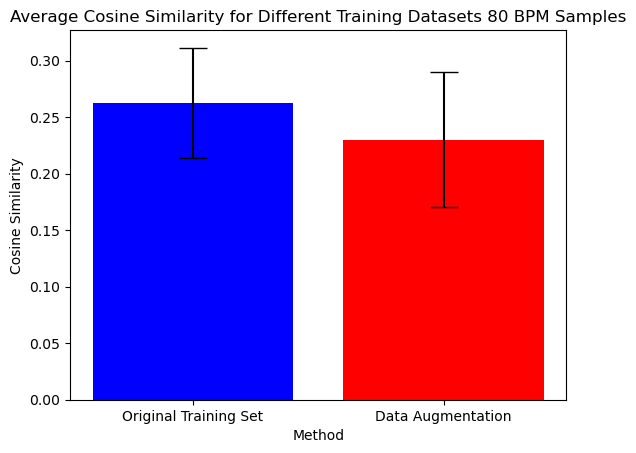

In [15]:
plt.bar(["Original Training Set", "Data Augmentation"], 
        [np.mean(results_80_orig), np.mean(results_80_aug)], 
        color = ["blue", "red"], 
        yerr = [CI_80_orig[1] - np.mean(results_80_orig), CI_80_aug[1] - np.mean(results_80_aug)], capsize = 10)
plt.title("Average Cosine Similarity for Different Training Datasets 80 BPM Samples")
plt.xlabel("Method")
plt.ylabel("Cosine Similarity")

Text(0, 0.5, 'Cosine Similarity')

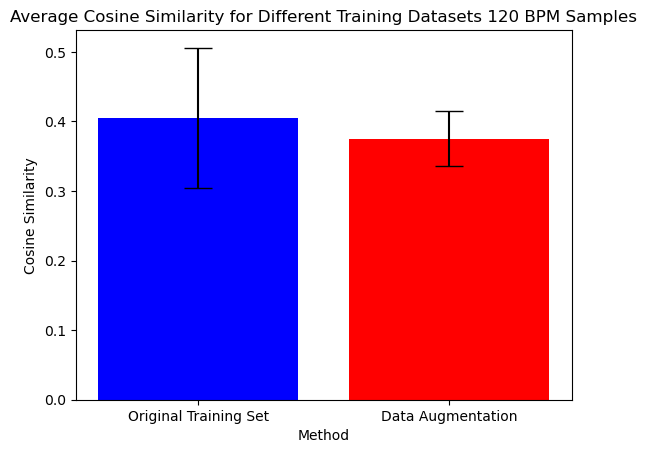

In [16]:
plt.bar(["Original Training Set", "Data Augmentation"], 
        [np.mean(results_120_orig), np.mean(results_120_aug)], 
        color = ["blue", "red"], 
        yerr = [CI_120_orig[1] - np.mean(results_120_orig), CI_120_aug[1] - np.mean(results_120_aug)], capsize = 10)
plt.title("Average Cosine Similarity for Different Training Datasets 120 BPM Samples")
plt.xlabel("Method")
plt.ylabel("Cosine Similarity")

Text(0, 0.5, 'Cosine Similarity')

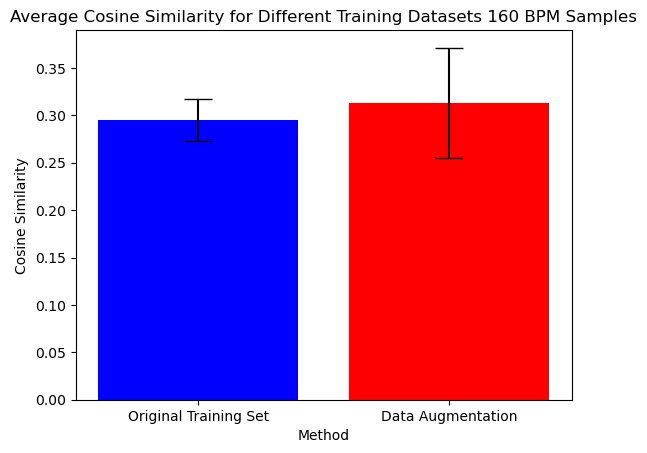

In [17]:
plt.bar(["Original Training Set", "Data Augmentation"], 
        [np.mean(results_160_orig), np.mean(results_160_aug)], 
        color = ["blue", "red"], 
        yerr = [CI_160_orig[1] - np.mean(results_160_orig), CI_160_aug[1] - np.mean(results_160_aug)], capsize = 10)
plt.title("Average Cosine Similarity for Different Training Datasets 160 BPM Samples")
plt.xlabel("Method")
plt.ylabel("Cosine Similarity")